In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
import awkward as ak

In [39]:
directory="/Users/ryan/arratia_lab/PTRG_Analysis/"
os.chdir(directory)

#make new folder called run data here 
#route all saved images there

# Dataframe Creation

In [40]:
#PTRIG
run=360
with open(f'Run{run}_list.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
timeStamps = []
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;
#    print(line)
    split = line.split()
    layer, channel, LG, HG = split[0:4]
#    ID=f"{layer}-{channel}"
    ID=int(layer)*64+int(channel)
    #print(ID)
    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))
#print(din)

#making lists the same length
max_len = max(len(lst) for lst in din.values())

din = {key: lst + [np.nan]*(max_len - len(lst)) for key, lst in din.items()}
        



#check if same length
max_column = max(din, key=lambda col: len(din[col]))
min_column = min(din, key=lambda col: len(din[col]))
print(max_column)
print(len(din[max_column]))
print()
print(min_column)
print(len(din[min_column]))

#print(din['320_HG'])

#This says ptrig, but could be used for either ptrig or cosmic data. Just label which is which
ptrigDF = pd.DataFrame(din)



print(f"Done! Total events: {len(ptrigDF)}")
PTRIGpickle_file_name='./PTRIG_LG50_HG50_4k_R9.pkl'
ptrigDF.to_pickle(PTRIGpickle_file_name)



0_LG
1838

0_LG
1838
Done! Total events: 1838


# Analysis

### LG and HG Means per Channel

In [41]:
# Extracting HG and LG columns
HG_columns = [col for col in ptrigDF.columns if 'HG' in col]
LG_columns = [col for col in ptrigDF.columns if 'LG' in col]

# Creating HG and LG values list
HG_Ped_values = [np.array(ptrigDF[col].tolist()) for col in HG_columns]
LG_Ped_values = [np.array(ptrigDF[col].tolist()) for col in LG_columns]

# Sorting columns and values together
HG_sorted = sorted(zip(HG_columns, HG_Ped_values), key=lambda x: int(x[0].split('_')[0]))
LG_sorted = sorted(zip(LG_columns, LG_Ped_values), key=lambda x: int(x[0].split('_')[0]))

# Unzipping back into separate lists
HG_columns_sorted, HG_Ped_values_sorted = zip(*HG_sorted)
LG_columns_sorted, LG_Ped_values_sorted = zip(*LG_sorted)




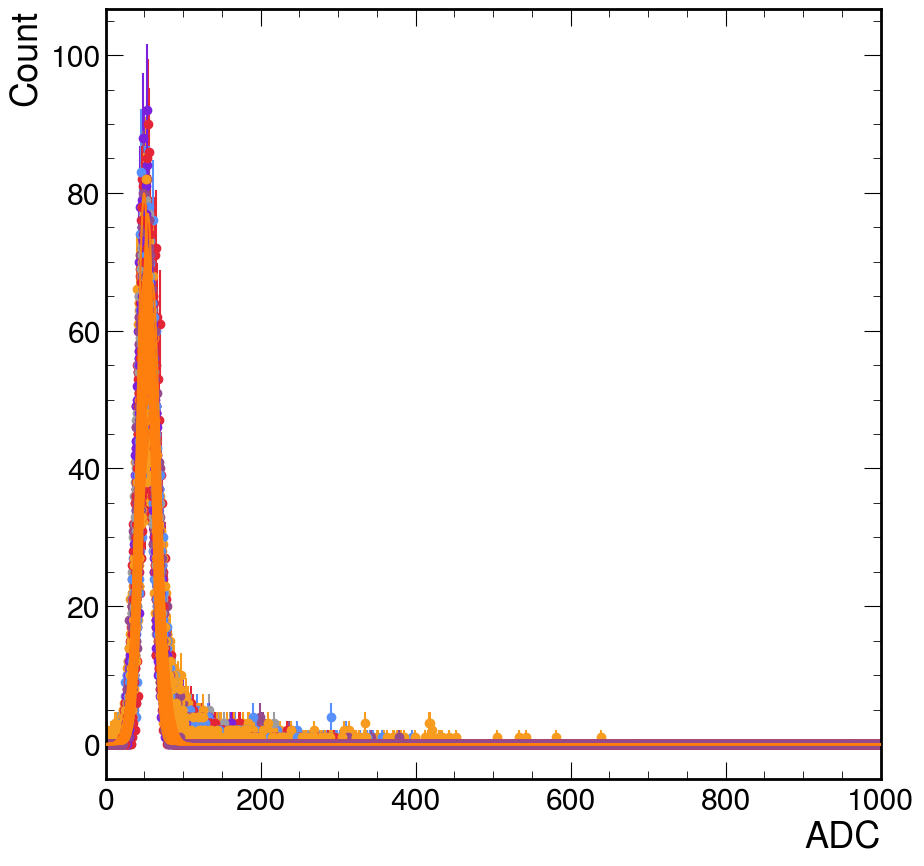

In [42]:
HGPeds = []
HGPedStd = []
HGErrorlist=[]
problems=[]
num_channels = 25
start = 0

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Determine the grid size
num_cols = 5
num_rows = (num_channels + num_cols - 1) // num_cols
num_rows=5
# Create a figure and grid of subplots
# Plot histogram for each channel
#print(HG_Ped_values)
for i, HG_branch in enumerate(HG_Ped_values_sorted):
    HG_mask=np.array(HG_branch)<1000
    HG_branch_filtered=HG_branch[HG_mask]
    data = HG_branch_filtered
    bins = int(np.sqrt(len(data)))
    counts, bin_edges = np.histogram(data[data>0], bins=1000,range=[0,1000])
    #print(counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)


    # Plot the histogram with error bars and the KDE
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')
    
    mask = (counts > 0)

    initial_params = [max(counts[mask]),np.mean(data),np.std(data)]
    m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    x = np.linspace(0,1000, 1500)
    plt.xlim(0,1000)
    #plt.ylim(0,0.010)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, color='tab:orange', zorder=101)
    HGPeds.append(mu_fit)
    HGPedStd.append(sigma_fit)

    HGErrorlist.append(errors[1])


    #print(len(counts[mask]))
    #print(len(bin_centers[mask]))
          
#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles[::-1], labels[::-1], fontsize=20)
    
    plt.ylabel('Count')
    plt.xlabel('ADC')
        


## Trouble Graphs HG

<ErrorView A=2.036085314294595 mu=0.2730980972533725 sigma=0.23916030360491636>
<ValueView A=62.8284913412575 mu=50.75978206061232 sigma=10.697958772231024>


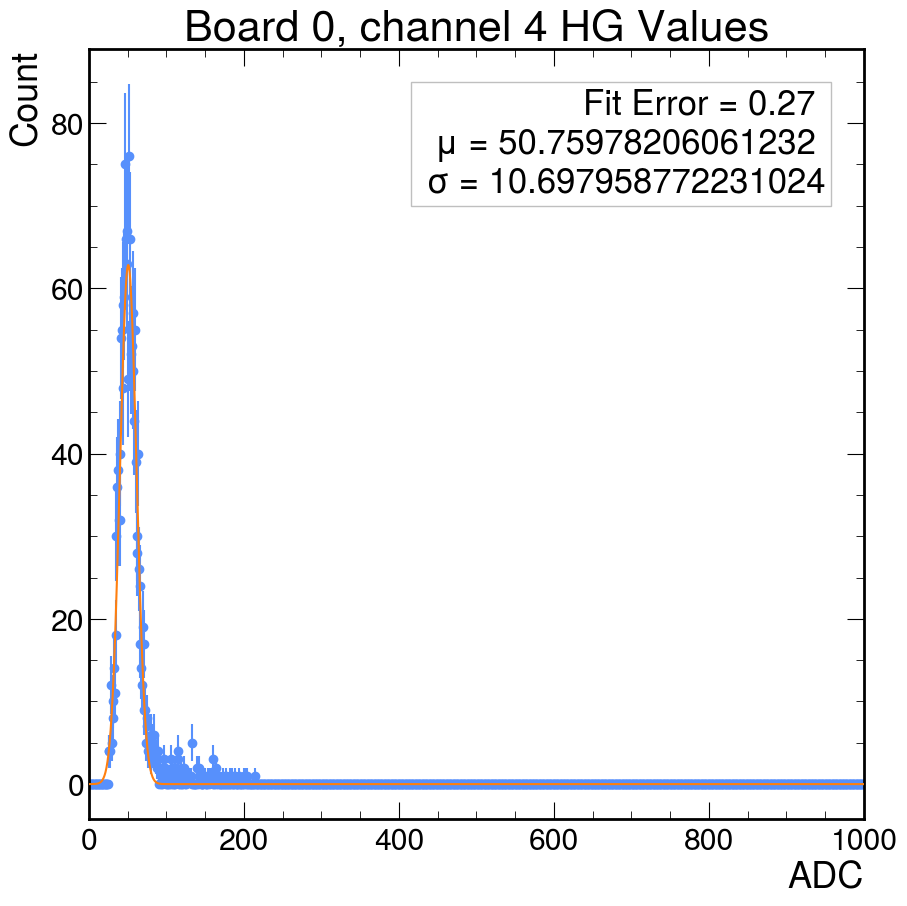

In [44]:
ID_num=4
singledata=HG_Ped_values_sorted[ID_num]
singledata=singledata[~np.isnan(singledata)]
singledata=singledata[singledata>0]
#bins = int(np.sqrt(len(singledata)))
counts, bin_edges = np.histogram(singledata, bins=1000, range=[0,1000])
#print(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
bin_centers = np.array(bin_centers)
counts = np.array(counts)


plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')

# Plot the histogram with error bars and the KDE

mask = (counts > 0)

initial_params = [max(counts[mask]),np.mean(singledata),np.std(singledata)]
m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0,1000, 1500)
plt.xlim(0,1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, color='tab:orange', zorder=101)

plt.ylabel('Count')
plt.xlabel('ADC')
plt.text(0.95, 0.95, f"Fit Error = {np.mean(errors[1]):.2f} \n \u03BC = {m.values[1]} \n \u03C3 = {m.values[2]}", 
         transform=plt.gca().transAxes,   # use axis coordinate system (0,0 bottom-left to 1,1 top-right)
         fontsize=25, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

channel_num=ID_num%64
board_num=int((ID_num-channel_num)/64)
plt.title(f"Board {board_num}, channel {channel_num} HG Values")
print(errors)
print(m.values)

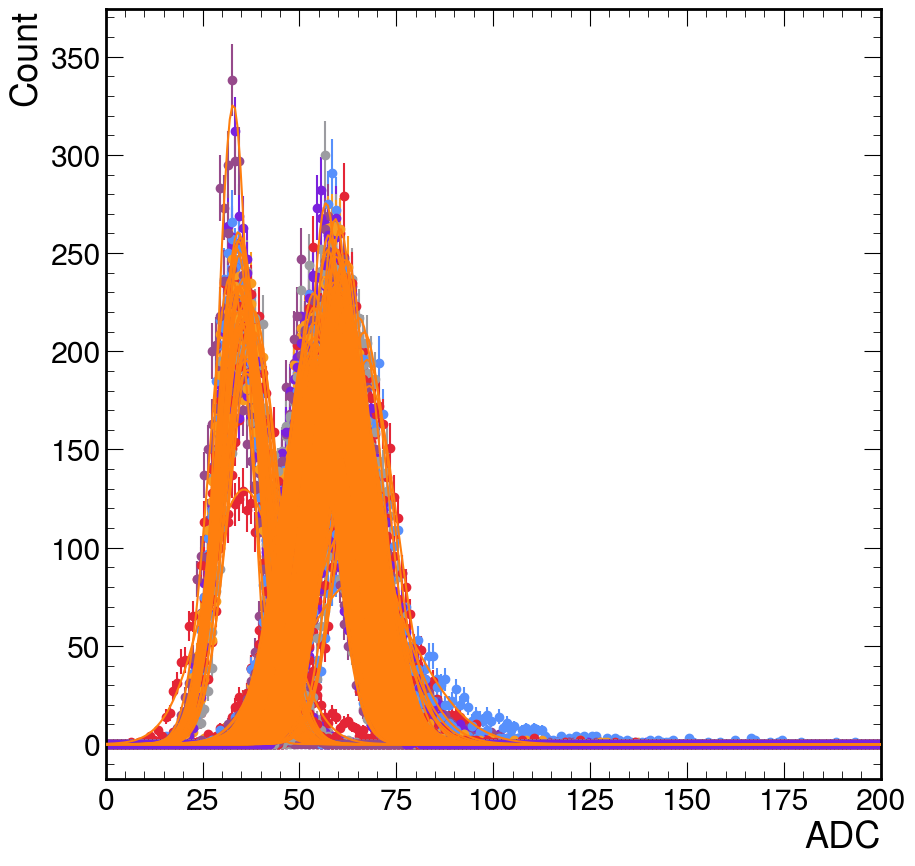

In [ ]:
LGPeds = []
LGPedStd = []
LGErrorlist=[]
num_channels = 25
start = 0

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'
hep.style.use(hep.style.CMS)

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Determine the grid size
num_cols = 5
num_rows = (num_channels + num_cols - 1) // num_cols
num_rows=5
# Create a figure and grid of subplots
# Plot histogram for each channel
#print(HG_Ped_values)
for i, LG_branch in enumerate(LG_Ped_values_sorted):
    LG_mask=np.array(LG_branch)<1000
    data = LG_branch[LG_mask]
    bins = int(np.sqrt(len(data)))
    counts, bin_edges = np.histogram(data[data>0], bins=200,range=[0,200])
    #print(counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)


    # Plot the histogram with error bars and the KDE
    plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')
    
    mask = (counts > 0)

    initial_params = [max(counts[mask]),np.mean(data),np.std(data)]
    m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    x = np.linspace(0,1000, 1500)
    plt.xlim(0,200)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, color='tab:orange', zorder=101)
    LGPeds.append(mu_fit)
    LGPedStd.append(sigma_fit)

    LGErrorlist.append(errors[1])

    #print(len(counts[mask]))
    #print(len(bin_centers[mask]))
          
#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles[::-1], labels[::-1], fontsize=20)
    
    plt.ylabel('Count')
    plt.xlabel('ADC')
        


## Trouble Graphs LG

<ErrorView A=3.052068608452115 mu=0.16649883793980008 sigma=0.12283048828628385>
<ValueView A=103.96515343629731 mu=55.05838216635017 sigma=6.9050917415153625>


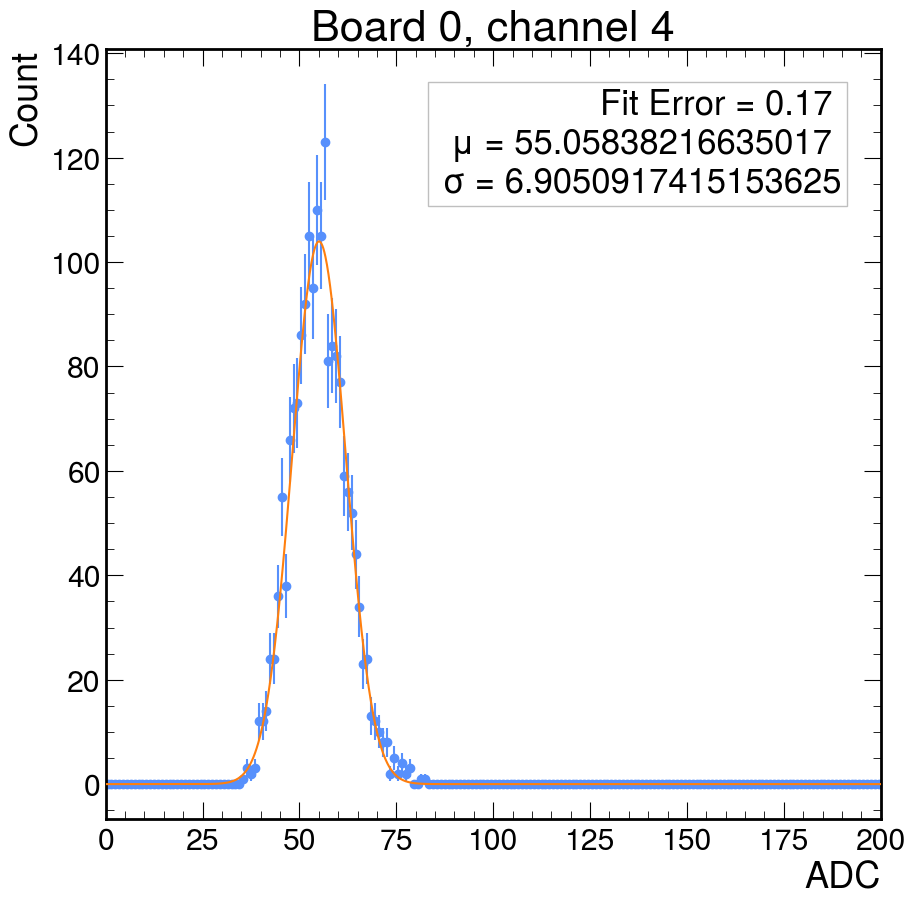

In [45]:
ID_num=4
singledata=LG_Ped_values_sorted[ID_num]
singledata=singledata[~np.isnan(singledata)]
singledata=singledata[singledata>0]
#bins = int(np.sqrt(len(singledata)))
counts, bin_edges = np.histogram(singledata, bins=200, range=[0,200])
#print(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
bin_centers = np.array(bin_centers)
counts = np.array(counts)


plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f'Ch {i}')

# Plot the histogram with error bars and the KDE

mask = (counts > 0)

initial_params = [max(counts[mask]),np.mean(singledata),np.std(singledata)]
m = Minuit(LeastSquares(bin_centers[mask], counts[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0,200, 1500)
plt.xlim(0,200)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, color='tab:orange', zorder=101)

plt.ylabel('Count')
plt.xlabel('ADC')
plt.text(0.95, 0.95, f"Fit Error = {np.mean(errors[1]):.2f} \n \u03BC = {m.values[1]} \n \u03C3 = {m.values[2]}", 
         transform=plt.gca().transAxes,   # use axis coordinate system (0,0 bottom-left to 1,1 top-right)
         fontsize=25, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

channel_num=ID_num%64
board_num=int((ID_num-channel_num)/64)
plt.title(f"Board {board_num}, channel {channel_num}")
print(errors)
print(m.values)

In [46]:
din2={}
HG_IDs=[]
LG_IDs=[]
for i, HG_branch in enumerate(HG_Ped_values_sorted):
    name=HG_columns_sorted[i]
    #print(name)
    HG_mask=np.array(HG_branch)<1000
    HG_branch_filtered=HG_branch[HG_mask]
    if name not in HG_IDs:
        din2[name] = []
        HG_IDs.append(name)
    din2[name].append(f"mean:{np.mean(HG_branch_filtered)}")
    din2[name].append(f"std:{np.std(HG_branch_filtered)}")
for i, LG_branch in enumerate((LG_Ped_values_sorted)):
    name=LG_columns_sorted[i]
    LG_mask=np.array(LG_branch)<1000
    LG_branch_filtered=LG_branch[LG_mask]
    if name not in LG_IDs:
        din2[name] = []
        LG_IDs.append(name)
    din2[name].append(f"mean:{np.mean(LG_branch)}")
    din2[name].append(f"std:{np.std(LG_branch)}")
#print(din2)

ptrigDF2 = pd.DataFrame(din2)
PTRIGpickle_file_name2='./PTRIG_R9_with_vals.pkl'
ptrigDF2.to_pickle(PTRIGpickle_file_name2)



In [47]:

os.chdir('run_data')
if not os.path.exists(f"Run{run}_graphs"):
    os.mkdir(f"Run{run}_graphs")
    print(f"Folder '{f"Run{run}_graphs"}' created.")
else:
    print(f"Folder '{f"Run{run}_graphs"}' already exists.")

Folder 'Run360_graphs' already exists.


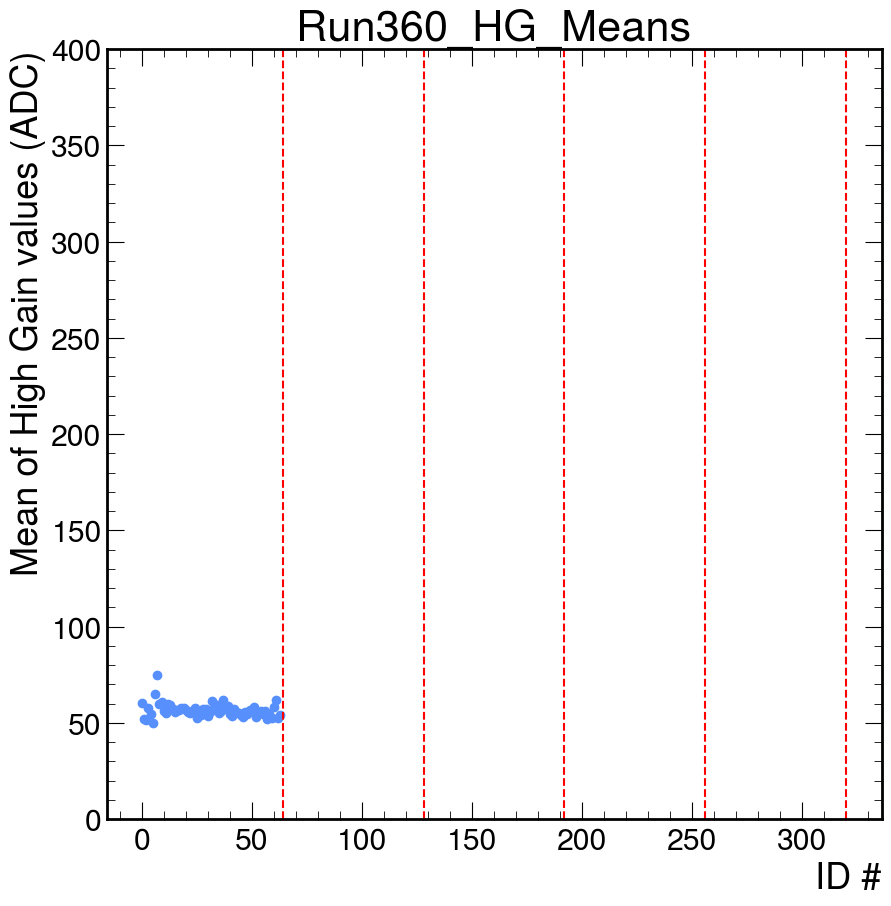

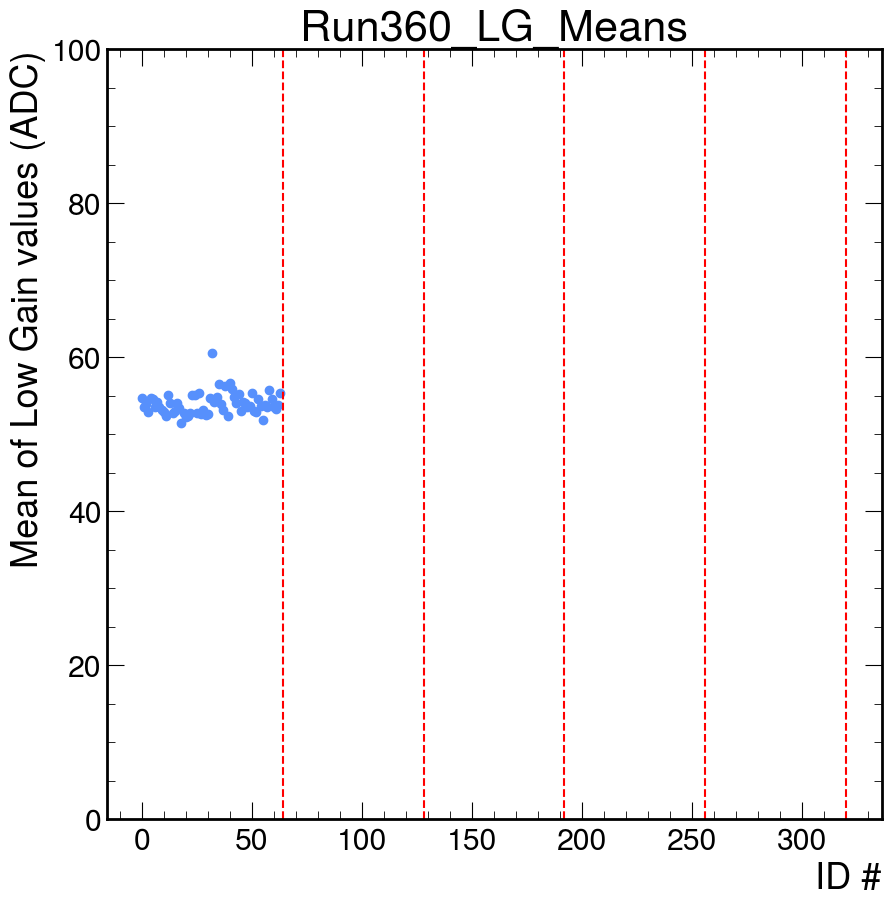

In [48]:
#Use gaussian means
#Draw HG/LG settings from info file
IDnums=[]
HG_means=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_mean=np.array(ptrigDF2[ID].tolist()[0])
    raw_meanstr=np.array2string(raw_mean)
    raw_meanstr=raw_meanstr[:-1]
    HG_means.append(raw_meanstr.split(':')[1])

plt.title(f'Run{run}_HG_Means')
plt.scatter(list(map(int, IDnums)),list(map(float,HG_means)))
plt.xlabel('ID #')
plt.ylabel('Mean of High Gain values (ADC)')
plt.ylim(0,400)

for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')
    
plt.savefig(f"Run{run}_graphs/Run{run}_HG_Means.png")

IDnums=[]
LG_means=[]
for ID in LG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_mean=np.array(ptrigDF2[ID].tolist()[0])
    raw_meanstr=np.array2string(raw_mean)
    raw_meanstr=raw_meanstr[:-1]
    LG_means.append(raw_meanstr.split(':')[1])

plt.figure()
plt.title(f"Run{run}_LG_Means")
plt.scatter(list(map(int,IDnums)),list(map(float,LG_means)))
plt.xlabel('ID #')
plt.ylabel('Mean of Low Gain values (ADC)')
plt.ylim(0,100)





for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_LG_Means.png")

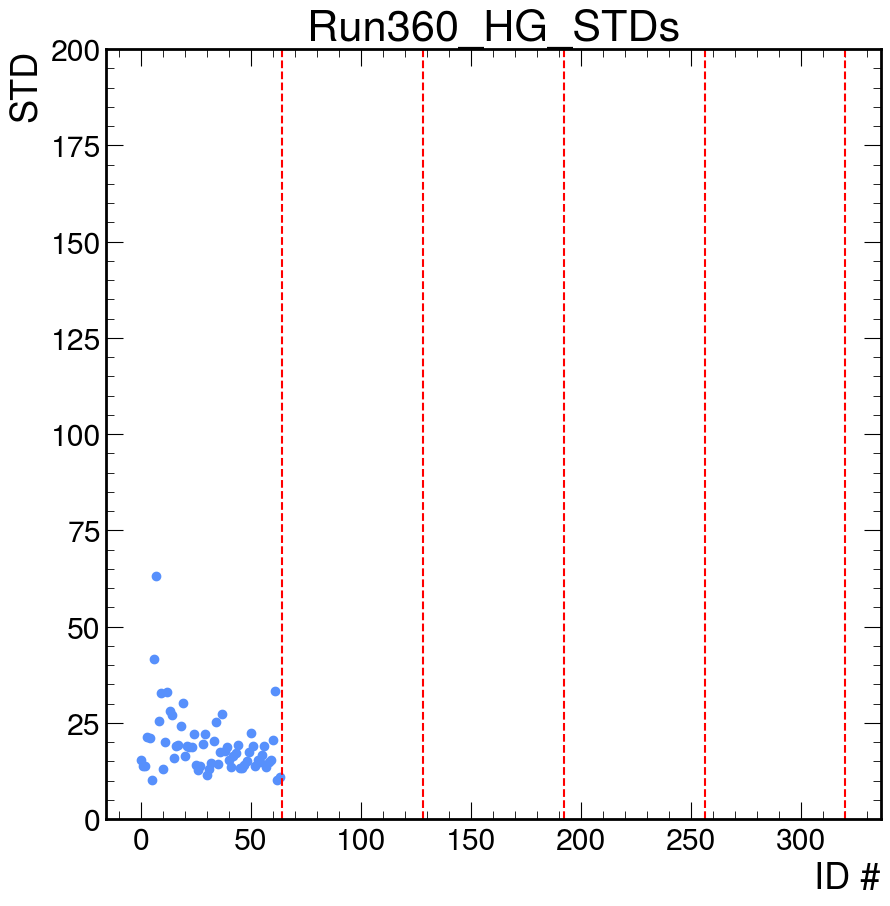

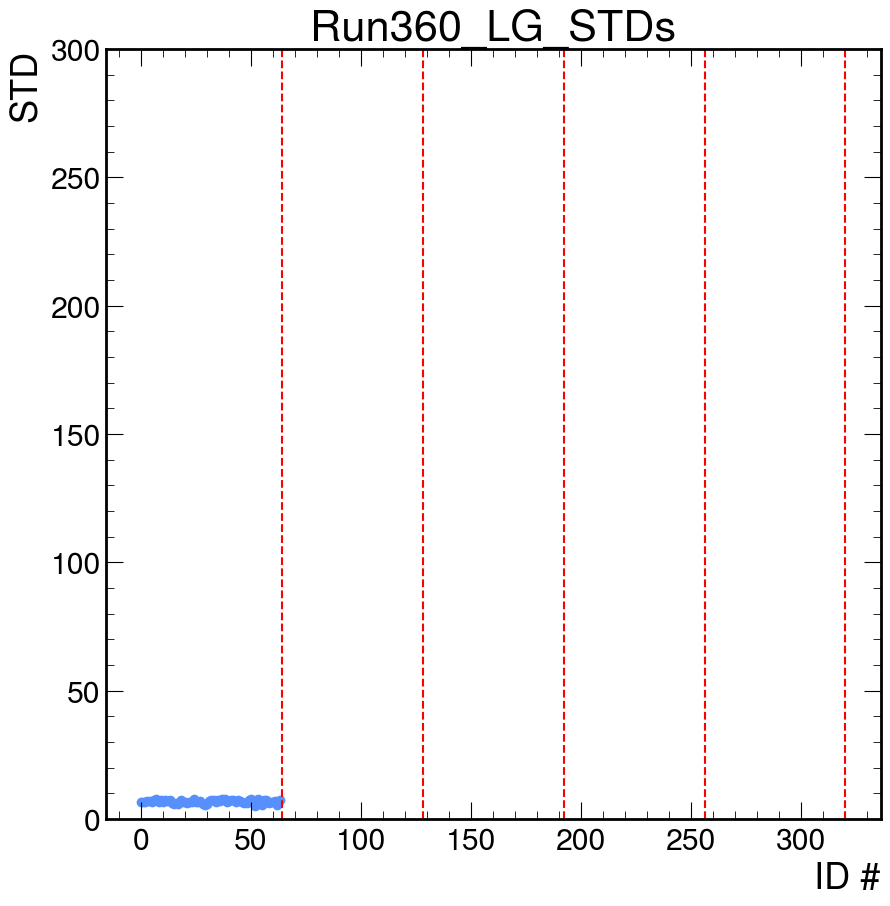

In [49]:
#Use gaussian stds
IDnums=[]
HG_stds=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_std=np.array(ptrigDF2[ID].tolist()[1])
    raw_stdstr=np.array2string(raw_std)
    raw_stdstr=raw_stdstr[:-1]
    HG_stds.append(raw_stdstr.split(':')[1])

plt.title(f'Run{run}_HG_STDs')
plt.xlabel('ID #')
plt.ylabel('STD')
plt.scatter(list(map(int,IDnums)),list(map(float,HG_stds)))
plt.ylim(0,200)
for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_HG_STDS.png")

IDnums=[]
LG_stds=[]
for ID in LG_IDs:
    IDnums.append(ID.split('_')[0])
    raw_std=np.array(ptrigDF2[ID].tolist()[1])
    raw_stdstr=np.array2string(raw_std)
    raw_stdstr=raw_stdstr[:-1]
    LG_stds.append(raw_stdstr.split(':')[1])

plt.figure()
plt.title(f'Run{run}_LG_STDs')
plt.xlabel('ID #')
plt.ylabel('STD')
plt.scatter(list(map(int,IDnums)),list(map(float,LG_stds)))
plt.ylim(0,300)


for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_LG_STDS.png")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


ValueError: x and y must be the same size

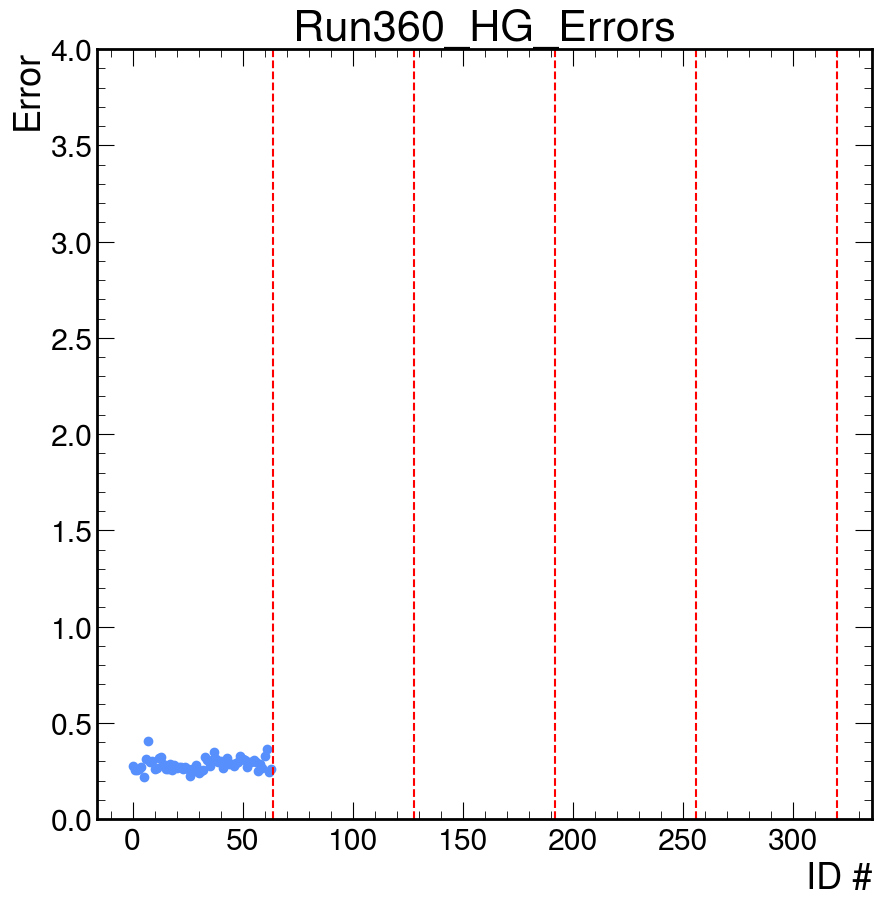

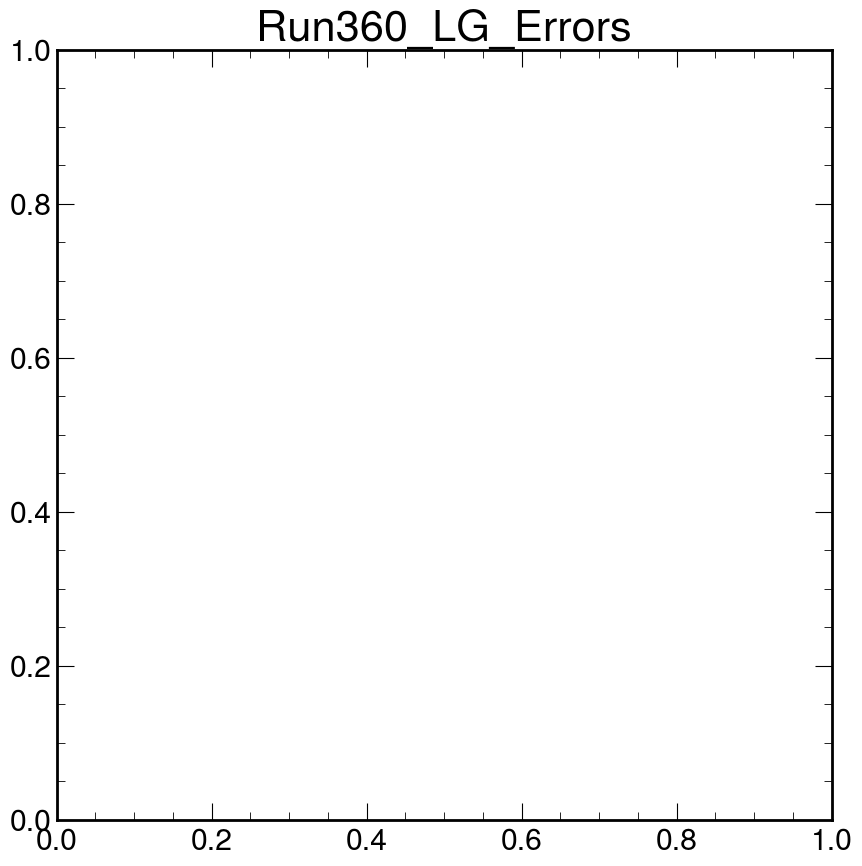

In [50]:
IDnums=[]
HG_errors=[]
for ID in HG_IDs:
    IDnums.append(ID.split('_')[0])
plt.title(f'Run{run}_HG_Errors')
print(list(map(int,IDnums)))
plt.scatter(list(map(int,IDnums)),HGErrorlist)
plt.xlabel('ID #')
plt.ylabel('Error')
plt.ylim(0,4)
for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_HG_Errors.png")

for i, mean in enumerate(HGErrorlist):
    if mean>5:
        print(i, mean)

IDnums=[]
LG_errors=[]
for ID in LG_IDs:
    IDnums.append(ID.split('_')[0])

plt.figure()
plt.title(f'Run{run}_LG_Errors')
plt.scatter(list(map(int,IDnums)),LGErrorlist)
plt.xlabel('ID #')
plt.ylabel('Error')
plt.ylim(0,4)
for i in range(1,6): #5 is number of caen units
    plt.axvline(x=i*64, color='red', linestyle='--')

plt.savefig(f"Run{run}_graphs/Run{run}_LG_Errors.png")

print()
for i, mean in enumerate(LGErrorlist):
    if mean>5:
        print(i, mean)


In [51]:
file_path = './PTRIG_R9_with_vals.pkl'

# Open the pickle file in read-binary mode ('rb')
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

# Now you can use the loaded data
print(data)

FileNotFoundError: [Errno 2] No such file or directory: './PTRIG_R9_with_vals.pkl'